In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from sqlalchemy import create_engine
from ds100_utils import fetch_and_cache

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)

## SQL Joins

In [2]:
import sqlite3
conn = sqlite3.connect('test.db')

In [3]:
conn.executescript("""
DROP TABLE IF EXISTS s;
DROP TABLE IF EXISTS t;

CREATE TABLE s(
    id INTEGER PRIMARY KEY, 
    name TEXT
);

INSERT INTO s VALUES 
    (0, 'Apricot'),
    (1, 'Boots'),
    (2, 'Cally'),
    (4, 'Eugene');

CREATE TABLE t(
    id INTEGER PRIMARY KEY,
    breed TEXT
);

INSERT INTO t VALUES 
    (1, 'persian'),
    (2, 'ragdoll'),
    (4, 'bengal'),
    (5, 'persian');
""");

In [4]:
def print_sql(s):
    first, *rest = s.strip().split('\n')
    print(f'sql> {first}')
    for line in rest:
        print(f'...> {line}')
    for result in conn.execute(s):
        print(result)

print_sql('SELECT * FROM s;')
print_sql('SELECT * FROM t;')

sql> SELECT * FROM s;
(0, 'Apricot')
(1, 'Boots')
(2, 'Cally')
(4, 'Eugene')
sql> SELECT * FROM t;
(1, 'persian')
(2, 'ragdoll')
(4, 'bengal')
(5, 'persian')


In [5]:
query = '''
SELECT *
FROM s
WHERE id >= 2;
'''

print_sql(query)

sql> SELECT *
...> FROM s
...> WHERE id >= 2;
(2, 'Cally')
(4, 'Eugene')


In [6]:
#cross join
query = '''
SELECT *
FROM s, t
'''
print_sql(query)

sql> SELECT *
...> FROM s, t
(0, 'Apricot', 1, 'persian')
(0, 'Apricot', 2, 'ragdoll')
(0, 'Apricot', 4, 'bengal')
(0, 'Apricot', 5, 'persian')
(1, 'Boots', 1, 'persian')
(1, 'Boots', 2, 'ragdoll')
(1, 'Boots', 4, 'bengal')
(1, 'Boots', 5, 'persian')
(2, 'Cally', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(2, 'Cally', 4, 'bengal')
(2, 'Cally', 5, 'persian')
(4, 'Eugene', 1, 'persian')
(4, 'Eugene', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')
(4, 'Eugene', 5, 'persian')


In [7]:
#inner join
query = '''
SELECT *
FROM s JOIN t
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM s JOIN t
...>   ON s.id = t.id
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [8]:
#left outer join
query = '''
SELECT *
FROM s LEFT JOIN t
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM s LEFT JOIN t
...>   ON s.id = t.id
(0, 'Apricot', None, None)
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [9]:
#right inner join unsupported, so we have to switch s and t
query = '''
SELECT *
FROM t LEFT JOIN s
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM t LEFT JOIN s
...>   ON s.id = t.id
(1, 'persian', 1, 'Boots')
(2, 'ragdoll', 2, 'Cally')
(4, 'bengal', 4, 'Eugene')
(5, 'persian', None, None)


Doing an outer join is possible but is not very concise and requires UNION keyword.

In [10]:
#full outer join with UNION
query = '''
SELECT s.id, s.name, t.id, t.breed
FROM s LEFT JOIN t
  ON s.id = t.id
UNION
SELECT s.id, s.name, t.id, t.breed
FROM t LEFT JOIN s
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT s.id, s.name, t.id, t.breed
...> FROM s LEFT JOIN t
...>   ON s.id = t.id
...> UNION
...> SELECT s.id, s.name, t.id, t.breed
...> FROM t LEFT JOIN s
...>   ON s.id = t.id
(None, None, 5, 'persian')
(0, 'Apricot', None, None)
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


## IMDB Data

In [11]:
data_directory = './'

In [12]:
# From https://www.imdb.com/interfaces/
fetch_and_cache('https://datasets.imdbws.com/title.basics.tsv.gz', 'titles.tsv.gz', data_directory)
fetch_and_cache('https://datasets.imdbws.com/name.basics.tsv.gz', 'names.tsv.gz', data_directory)
!gunzip -kf {data_directory}/titles.tsv.gz
!gunzip -kf {data_directory}/names.tsv.gz
!ls -lh {data_directory}

Using cached version that was downloaded (UTC): Wed Jun 24 03:54:13 2020
Using cached version that was downloaded (UTC): Wed Jun 24 03:54:18 2020
total 2.7G
-rw-r--r-- 1 jovyan jovyan 1.7K Jun 24 00:31 ds100_utils.py
-rw-r--r-- 1 jovyan jovyan 1.3G Jun 25 06:54 imdb.db
-rw-r--r-- 1 jovyan jovyan 324K Jun 25 06:59 lec04.ipynb
-rw-r--r-- 1 jovyan jovyan 581M Jun 24 03:54 names.tsv
-rw-r--r-- 1 jovyan jovyan 190M Jun 24 03:54 names.tsv.gz
drwxr-xr-x 2 jovyan jovyan 4.0K Jun 25 06:59 __pycache__
-rw-r--r-- 1 jovyan jovyan  12K Jun 25 06:59 test.db
-rw-r--r-- 1 jovyan jovyan 562M Jun 24 03:54 titles.tsv
-rw-r--r-- 1 jovyan jovyan 118M Jun 24 03:54 titles.tsv.gz


In [13]:
# Running the line below will probaly crash your kernel because the names 
# dataset is too big to comfortable fit into main memory. 
#pd.read_csv(f'{data_directory}/names.tsv', sep='\t')

In [14]:
# Use sqlite3 instead of Python (must be run from the terminal)
# note: To close sqlite3, press ctrl-d
"""
$ sqlite3 imdb.db
sqlite> .mode tabs
sqlite> .import titles.tsv titles
sqlite> .import names.tsv names
""";

While the code above runs, let's explore the data files a bit.

In [15]:
!wc {data_directory}/*.tsv

  10181040   70045544  608532078 .//names.tsv
   6921619   93944819  588641553 .//titles.tsv
  17102659  163990363 1197173631 total


In [16]:
!head -n5 {data_directory}/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	12	Animation,Short


In [17]:
!head -n5 {data_directory}/names.tsv

nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000001	Fred Astaire	1899	1987	soundtrack,actor,miscellaneous	tt0050419,tt0072308,tt0043044,tt0053137
nm0000002	Lauren Bacall	1924	2014	actress,soundtrack	tt0038355,tt0037382,tt0117057,tt0071877
nm0000003	Brigitte Bardot	1934	\N	actress,soundtrack,music_department	tt0049189,tt0054452,tt0059956,tt0057345
nm0000004	John Belushi	1949	1982	actor,soundtrack,writer	tt0078723,tt0077975,tt0072562,tt0080455


In [18]:
conn = sqlite3.connect(data_directory + '/imdb.db')
print_sql('SELECT * FROM titles LIMIT 10;')

sql> SELECT * FROM titles LIMIT 10;
('tt0000001', 'short', 'Carmencita', 'Carmencita', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000002', 'short', 'Le clown et ses chiens', 'Le clown et ses chiens', '0', '1892', '\\N', '5', 'Animation,Short')
('tt0000003', 'short', 'Pauvre Pierrot', 'Pauvre Pierrot', '0', '1892', '\\N', '4', 'Animation,Comedy,Romance')
('tt0000004', 'short', 'Un bon bock', 'Un bon bock', '0', '1892', '\\N', '12', 'Animation,Short')
('tt0000005', 'short', 'Blacksmith Scene', 'Blacksmith Scene', '0', '1893', '\\N', '1', 'Comedy,Short')
('tt0000006', 'short', 'Chinese Opium Den', 'Chinese Opium Den', '0', '1894', '\\N', '1', 'Short')
('tt0000007', 'short', 'Corbett and Courtney Before the Kinetograph', 'Corbett and Courtney Before the Kinetograph', '0', '1894', '\\N', '1', 'Short,Sport')
('tt0000008', 'short', 'Edison Kinetoscopic Record of a Sneeze', 'Edison Kinetoscopic Record of a Sneeze', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000009', 'movie', 'M

In [19]:
for exp in conn.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE titles(
  "tconst" TEXT,
  "titleType" TEXT,
  "primaryTitle" TEXT,
  "originalTitle" TEXT,
  "isAdult" TEXT,
  "startYear" TEXT,
  "endYear" TEXT,
  "runtimeMinutes" TEXT,
  "genres" TEXT
)
CREATE TABLE names(
  "nconst" TEXT,
  "primaryName" TEXT,
  "birthYear" TEXT,
  "deathYear" TEXT,
  "primaryProfession" TEXT,
  "knownForTitles" TEXT
)
CREATE TABLE s(
    id INTEGER PRIMARY KEY, 
    name TEXT
)
CREATE TABLE t(
    id INTEGER PRIMARY KEY,
    breed TEXT
)
CREATE TABLE action_movie(
  id TEXT,
  title TEXT,
  time INT,
  year INT
)
CREATE TABLE action_ppl(
  name TEXT,
  profession,
  born INT,
  title TEXT,
  year INT
)


In [20]:
# Reminder: Python f strings
who, where = 'John', 'here'
f"{who} is {where}"

'John is here'

In [21]:
get_10_movies = f'''
SELECT primaryTitle AS title, 
  runtimeMinutes AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies)

sql> SELECT primaryTitle AS title, 
...>   runtimeMinutes AS time
...> FROM titles
...> LIMIT 10;
('Carmencita', '1')
('Le clown et ses chiens', '5')
('Pauvre Pierrot', '4')
('Un bon bock', '12')
('Blacksmith Scene', '1')
('Chinese Opium Den', '1')
('Corbett and Courtney Before the Kinetograph', '1')
('Edison Kinetoscopic Record of a Sneeze', '1')
('Miss Jerry', '45')
('Leaving the Factory', '1')


In [22]:
get_10_movies_time_as_int = f'''
SELECT primaryTitle AS title, 
  CAST(runtimeMinutes as int) AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies_time_as_int)

sql> SELECT primaryTitle AS title, 
...>   CAST(runtimeMinutes as int) AS time
...> FROM titles
...> LIMIT 10;
('Carmencita', 1)
('Le clown et ses chiens', 5)
('Pauvre Pierrot', 4)
('Un bon bock', 12)
('Blacksmith Scene', 1)
('Chinese Opium Den', 1)
('Corbett and Courtney Before the Kinetograph', 1)
('Edison Kinetoscopic Record of a Sneeze', 1)
('Miss Jerry', 45)
('Leaving the Factory', 1)


In [23]:
select_action = f'''
SELECT tconst AS id,
  primaryTitle AS title, 
  CAST(runtimeMinutes AS int) AS time, 
  CAST(startYear AS int) AS year
FROM titles
WHERE genres LIKE '%Action%' AND
  year > 1900 AND 
  isAdult = '0' AND
  titleType = 'movie' AND
  time > 60 AND time < 180
'''

create_action_table = f'''
DROP TABLE IF EXISTS action_movie;
CREATE TABLE action_movie AS {select_action};
'''

conn.executescript(create_action_table)
print_sql('SELECT * FROM action_movie LIMIT 10')

sql> SELECT * FROM action_movie LIMIT 10
('tt0004223', 'The Life of General Villa', 105, 1914)
('tt0004450', 'Die Pagode', 82, 1917)
('tt0004635', 'The Squaw Man', 74, 1914)
('tt0005073', 'The Chalice of Courage', 65, 1915)
('tt0006333', '20,000 Leagues Under the Sea', 105, 1916)
('tt0006997', 'The Warrior', 95, 1916)
('tt0007168', 'Die Peitsche', 85, 1916)
('tt0008114', 'Die Hochzeit im Excentricclub', 70, 1917)
('tt0008915', 'Bound in Morocco', 64, 1918)
('tt0009560', 'The Romance of Tarzan', 70, 1918)


We can check to see whether this table is small enough to read into pandas:

In [24]:
print_sql('SELECT COUNT(*) from action_movie')

sql> SELECT COUNT(*) from action_movie
(21241,)


In [25]:
df = pd.read_sql('SELECT * FROM action_movie', conn)
df

,id,title,time,year
0,tt0004223,The Life of General Villa,105,1914
1,tt0004450,Die Pagode,82,1917
2,tt0004635,The Squaw Man,74,1914
...,...,...,...,...
21238,tt9897764,River Pirates,90,2018
21239,tt9898858,Coffee & Kareem,88,2020
21240,tt9904066,Fox Hunting,66,2019


In [26]:
df.shape

(21241, 4)

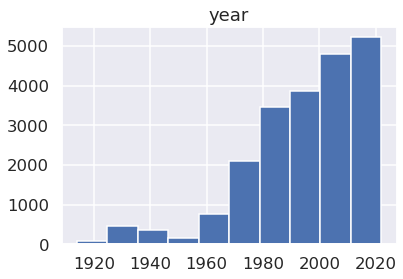

In [27]:
df.hist('year');

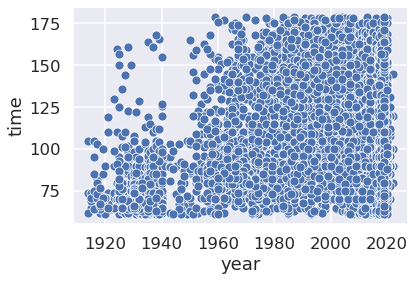

In [28]:
sns.scatterplot(df['year'], df['time']);

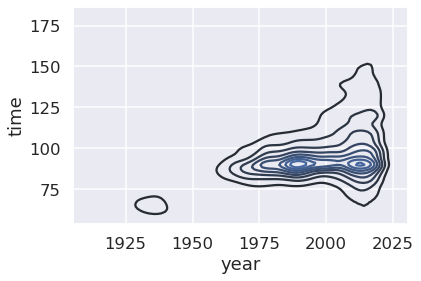

In [29]:
sns.kdeplot(df['year'], df['time']);

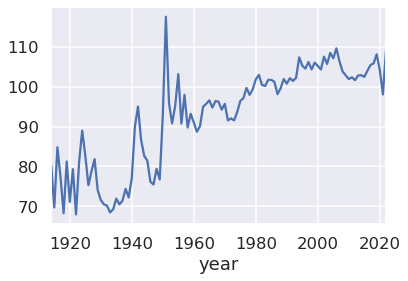

In [30]:
df['time'].groupby(df['year']).mean().plot();

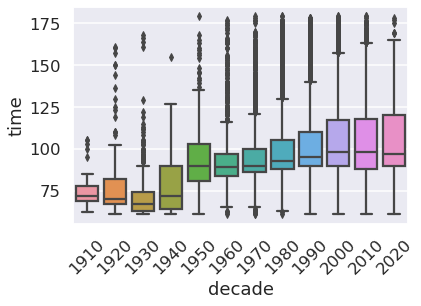

In [31]:
df['decade'] = (df['year'] // 10) * 10
sns.boxplot('decade', 'time', data=df)
plt.xticks(rotation=45);

## Sampling in SQL

In [32]:
pd.read_sql('SELECT * FROM action_movie ORDER BY RANDOM() LIMIT 3', conn)

,id,title,time,year
0,tt0093639,No Safe Haven,95,1987
1,tt0406941,Lorelei: The Witch of the Pacific Ocean,128,2005
2,tt6409600,Gyangû no shôzo,90,1965


In [33]:
#selecting 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

pd.read_sql(three_years, conn)

,year
0,1921
1,1940
2,1942


In [34]:
#selecting all movies from 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

cluster_sample = f'''
SELECT * FROM action_movie 
WHERE year IN ({three_years})
'''

pd.read_sql(f'''
SELECT *
FROM ({cluster_sample}) 
''', conn)

,id,title,time,year
0,tt0016570,Abrek Zaur,85,1926
1,tt0016615,Atta Boy,63,1926
2,tt0016630,Battling Butler,77,1926
...,...,...,...,...
1081,tt9844256,Code Geass: Lelouch of the Rebellion III - Glo...,120,2018
1082,tt9849122,Sriman Surdas,157,2018
1083,tt9897764,River Pirates,90,2018


In [35]:
# Query has two select statements
# Inner select statement creates the table of 3 randomly chosen years.
print(cluster_sample)


SELECT * FROM action_movie 
WHERE year IN (
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
)



## Ages of Fame

#### CASE Example

In [36]:
#case statement example
pd.read_sql('''
SELECT id, title, time, year,
     CASE WHEN time < 70 THEN 'short'
          WHEN time < 120 THEN 'medium'
          ELSE 'long'
     END as length
          
FROM action_movie
''', conn).sample(10)

,id,title,time,year,length
14329,tt1413492,12 Strong,130,2018,long
11737,tt0484964,"Bañeros III, todopoderosos",92,2006,medium
19528,tt6097226,The Oil Wrestler,76,2020,medium
...,...,...,...,...,...
17030,tt2565750,Aragure,76,2013,medium
2051,tt0089652,My Science Project,94,1985,medium
795,tt0073702,The Boss's Head,94,1975,medium


In [37]:
#case statement example with a base expression
pd.read_sql('''
SELECT id, title, time, year,
     CASE year LIKE '%197%' WHEN True THEN '70s'          
          ELSE 'not 70s'
     END as decade
          
FROM action_movie
''', conn).sample(10)

,id,title,time,year,decade
7102,tt0239395,Cats & Dogs,87,2001,not 70s
7840,tt0275688,Snipes,113,2001,not 70s
20331,tt7589670,Chalo,145,2018,not 70s
...,...,...,...,...,...
18174,tt3916762,Rabhasa,153,2014,not 70s
20845,tt8669144,Kuththu,156,2004,not 70s
571,tt0029813,Ski Battalion,73,1937,not 70s


#### SUBSTR Example

In [38]:
select_people = f'''
SELECT primaryName AS name, knownForTitles  
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

,name,knownForTitles
0,Fred Astaire,"tt0050419,tt0072308,tt0043044,tt0053137"
1,Lauren Bacall,"tt0038355,tt0037382,tt0117057,tt0071877"
2,Brigitte Bardot,"tt0049189,tt0054452,tt0059956,tt0057345"
...,...,...
7,Marlon Brando,"tt0068646,tt0070849,tt0047296,tt0078788"
8,Richard Burton,"tt0059749,tt0057877,tt0087803,tt0061184"
9,James Cagney,"tt0029870,tt0042041,tt0035575,tt0031867"


In [39]:
select_people = f'''
SELECT primaryName AS name,   
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS most_popular_id
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

,name,most_popular_id
0,Fred Astaire,tt0050419
1,Lauren Bacall,tt0038355
2,Brigitte Bardot,tt0049189
...,...,...
7,Marlon Brando,tt0068646
8,Richard Burton,tt0059749
9,James Cagney,tt0029870


### Age Trends

In [40]:
pd.read_sql('SELECT * FROM names LIMIT 10;', conn)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0043044,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0037382,tt0117057,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0059956,tt0057345"
...,...,...,...,...,...,...
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0068646,tt0070849,tt0047296,tt0078788"
8,nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0059749,tt0057877,tt0087803,tt0061184"
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0029870,tt0042041,tt0035575,tt0031867"


In [41]:
select_actors = f'''
SELECT primaryName AS name, 
  CAST(birthYear AS int) AS born,
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS movie_id,
  CASE WHEN primaryProfession LIKE '%actor%' THEN 'actor' 
    WHEN primaryProfession LIKE '%actress%' THEN 'actress'   
    END AS profession
FROM names
WHERE primaryProfession LIKE '%act%' AND
  born > 1800
'''

pd.read_sql(f'{select_actors} LIMIT 10', conn)

,name,born,movie_id,profession
0,Fred Astaire,1899,tt0050419,actor
1,Lauren Bacall,1924,tt0038355,actress
2,Brigitte Bardot,1934,tt0049189,actress
...,...,...,...,...
7,Marlon Brando,1924,tt0068646,actor
8,Richard Burton,1925,tt0059749,actor
9,James Cagney,1899,tt0029870,actor


In [42]:
select = f'''
SELECT name, profession, born, title, year
FROM ({select_actors}) JOIN action_movie
  ON movie_id = id;
'''

conn.executescript(f'''
DROP TABLE IF EXISTS action_ppl;
CREATE TABLE action_ppl AS {select};
''')

pd.read_sql('SELECT * FROM action_ppl LIMIT 10', conn)

,name,profession,born,title,year
0,John Belushi,actor,1949,1941,1979
1,Buster Keaton,actor,1895,"Steamboat Bill, Jr.",1928
2,Bruce Lee,actor,1940,Game of Death,1978
...,...,...,...,...,...
7,Antonio Banderas,actor,1960,Desperado,1995
8,Kim Basinger,actress,1953,Batman,1989
9,Matthew Broderick,actor,1962,WarGames,1983


The table above gives us all the people whose first movie in IMDB's "known for" list is an action movie, along with the name of that movie. We call these people "action people".

There's a lot we can do with this table, i.e. we can find all the people whose top role has the word "Vampire" in it.

In [43]:
vampire_people = '''
SELECT *
FROM action_ppl
WHERE title LIKE "%Vampire%"
'''

pd.read_sql(vampire_people, conn)

,name,profession,born,title,year
0,Thomas Ian Griffith,actor,1962,Vampires,1998
1,Susanna Hoffs,actress,1959,Buffy the Vampire Slayer,1992
2,Darian Caine,actress,1973,Fist of the Vampire,2007
...,...,...,...,...,...
51,Beth Hyland,actress,1976,Vampire Academy,2014
52,Beth Burvant,actress,1970,Cirque du Freak: The Vampire's Assistant,2009
53,"Natasha ""Sasha"" Angelety",actress,1981,Cirque du Freak: The Vampire's Assistant,2009


Or we can read in our dataframe into pandas and make a plot. Let's see the age of each actor when their best known movie was made.

In [44]:
df = pd.read_sql('SELECT * FROM action_ppl', conn)
df.shape

(18569, 5)

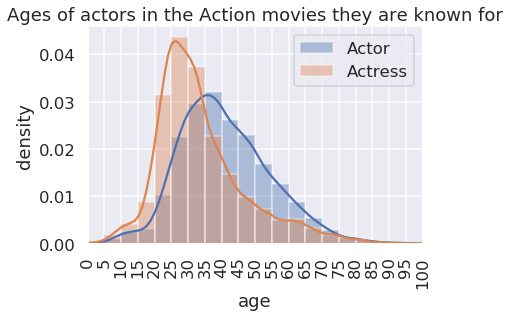

In [45]:
df['age'] = df['year'] - df['born']
bins = np.linspace(0, 100, 21)
sns.distplot(df[df['profession']=='actor']['age'], bins=bins)
sns.distplot(df[df['profession']=='actress']['age'], bins=bins)
plt.legend(labels=['Actor', 'Actress'])
plt.xticks(bins, rotation=90)
plt.xlim(0, 100)
plt.ylabel('density');
plt.title('Ages of actors in the Action movies they are known for');